In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.metrics import MeanSquaredError
from keras.layers import Bidirectional, Dense, LSTM, RepeatVector, TimeDistributed


%matplotlib notebook

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
np.random.seed(7)

In [3]:
# date parser
parser = lambda date: pd.to_datetime(date, format='%d-%m-%y %H:%M')

# load the dataset
dataframe = pd.read_csv(
    'EVANS-EFCO_clean_with_weather_and_2018.csv', parse_dates=[0],
    index_col=[0], date_parser=parser, engine='python'
)

## Note:

Divide dataset in to two: train_set (2016 & 2017), and test_set (2018).
Divide train_set into 4, use 3/4 for model training and 1/4 for validation.
predict 2018 and compare results.

In [4]:
dataframe.head(5)

,ENERGY CONSUMPTION,TEMPERATURE(C),PRESSURE,HUMIDITY,WEATHER CODE,WIND DIRECTION(DEGREE),WIND SPEED(KMPH),WORKDAY,PUBLIC HOLIDAY
DATE(HOURS/DAY/MONTH/YEAR),,,,,,,,,
2016-01-01 00:00:00,7.0,18,1014,48,113,44,4,1,1
2016-01-01 01:00:00,7.0,18,1014,44,113,37,5,1,1
2016-01-01 02:00:00,7.0,18,1014,40,113,31,6,1,1
2016-01-01 03:00:00,7.0,17,1014,36,113,24,6,1,1
2016-01-01 04:00:00,6.0,17,1014,35,113,24,6,1,1


In [5]:
training, testing = dataframe[:'2017'], dataframe['2018']

# Note: Dataset splitting

* ## Training
    * 3/4 => trainT or trainTra
    * 1/4 => trainV or trainVal
* ## Testing
    * test

In [6]:
def split_train_set():
    # Split into 3/4 and 1/4
    trainT, trainV = training[:'2017-06'], training['2017-07':]
    # 3/4 for training
    XtrainT, YtrainT = trainT.drop(['ENERGY CONSUMPTION'], axis=1).values, trainT['ENERGY CONSUMPTION'].values
    XtrainT, YtrainT = XtrainT.reshape(13113, 1, 8), YtrainT.reshape(13113, 1, 1)
    # 1/4 for validation
    XtrainV, YtrainV = trainV.drop(['ENERGY CONSUMPTION'], axis=1).values, trainV['ENERGY CONSUMPTION'].values
    XtrainV, YtrainV = XtrainV.reshape(4416, 1, 8), YtrainV.reshape(4416, 1, 1)
    
    return XtrainT, YtrainT, XtrainV, YtrainV

In [7]:
trainTraX, trainTraY, trainValX, trainValY = split_train_set()

In [8]:
def split_test_set():
    testX, testY = testing.drop(['ENERGY CONSUMPTION'], axis=1).values, testing['ENERGY CONSUMPTION'].values
    testX = testX.reshape(8760, 1, 8)
    return testX, testY

In [9]:
testX, testY = split_test_set()

# Model definition

In [10]:
model = load_model('stacked-encoder-decoder-lstm-model.h5')

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 50)             11800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 1, 50)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 1)              51        
Total params: 72,451
Trainable params: 72,451
Non-trainable params: 0
__________________________________________________

In [12]:
trainPredict = model.predict(trainTraX)

In [13]:
# Training input
trainX = dataframe[:'2017-06']['ENERGY CONSUMPTION'].values
# Training prediction
trainPredict = trainPredict.reshape(len(trainPredict),)

In [14]:
def prepare_date(from_date, to_date=None):
    # Input data for prediction
    inputX = dataframe[from_date].drop(['ENERGY CONSUMPTION'], axis=1).values
    # Actual consumption to be compared to prediction results
    inputY = dataframe[from_date]['ENERGY CONSUMPTION'].values
    
    if to_date:
        inputX = dataframe[from_date:to_date].drop(['ENERGY CONSUMPTION'], axis=1).values
        inputY = dataframe[from_date:to_date]['ENERGY CONSUMPTION'].values
    
    inputX = inputX.reshape(len(inputX), 1, 8)
    
    return inputX, inputY

In [15]:
def forecast_load(from_date, to_date=None):
    # pred_input => Prediction Input
    # actual => Actual consumption to be compared to prediction result
    pred_input, actual = prepare_date(from_date)
    
    if to_date:
        pred_input, actual = prepare_date(from_date, to_date)
    
    predicted = model.predict(pred_input)
    predicted = predicted.reshape(len(predicted),)
    
    return actual, predicted

In [16]:
x, y = forecast_load('2018')

In [ ]:
def mean_squared_error(x, y):
    m = MeanSquaredError()
    m.update_state(x, y)
    return m.result().numpy()

In [17]:
def root_mean_square_error(actual, predicted):
    rmse_score = math.sqrt(mean_squared_error(actual, predicted))
    print('Root Mean Square Error (RMSE) Score: {0:.2f}%'.format(rmse_score))

In [18]:
def mean_average_error(actual, predicted):
    mae_score = (actual - predicted).sum() / len(actual)
    print('Mean Average Error (MAE) Score: {0:.2f}'.format(mae_score))

In [19]:
def mean_average_percentage_error(actual, predicted):
    mape_score = (actual - predicted).sum() / len(actual) * 100
    print('Mean Average Percentage Error (MAPE) Score: {0:.2f}%'.format(mape_score))

In [20]:
# MSE score for training
print('Mean Square Error (MSE) Score: {0:.2f}'.format(mean_squared_error(trainX, trainPredict)))

Mean Square Error (MSE) Score: 791.93


In [21]:
# RMSE score for training
root_mean_square_error(trainX, trainPredict)

Root Mean Square Error (RMSE) Score: 28.14%


In [22]:
# MAE score for training
mae_score = (trainX - trainPredict).sum() / len(trainX)
print('Prediction Mean Average Error (MAE) Score: {0:.2f}'.format(mae_score))

Prediction Mean Average Error (MAE) Score: -1.60


In [23]:
# MAPE score for training
mean_average_percentage_error(trainX, trainPredict)

Mean Average Percentage Error (MAPE) Score: -160.38%


In [24]:
# MSE score for prediction
print('Mean Square Error (MSE) Score: {0:.2f}'.format(mean_squared_error(x, y)))

Mean Square Error (MSE) Score: 930.16


In [25]:
# RMSE score for prediction
root_mean_square_error(x, y)

Root Mean Square Error (RMSE) Score: 30.50%


In [26]:
# MAE score for prediction
mean_average_error(x, y)

Mean Average Error (MAE) Score: -6.85


In [27]:
# MAPE score for prediction
mean_average_percentage_error(x, y)

Mean Average Percentage Error (MAPE) Score: -684.85%


<IPython.core.display.Javascript object>


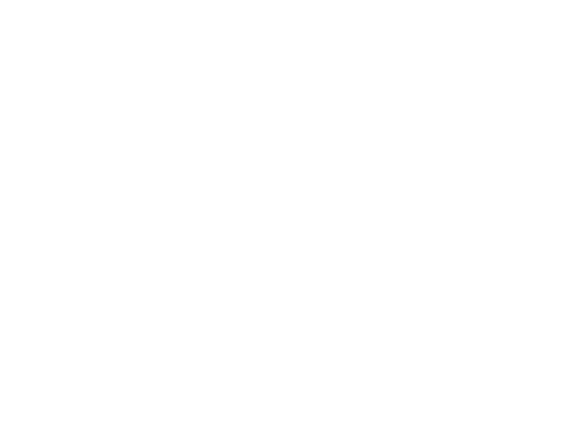

In [28]:
plt.plot(x)
plt.plot(y)
plt.show()

# Plots

In [29]:
def normalize_predicted_dataset(payload):
    date_index = dataframe.index[17544:]
    predicted = pd.DataFrame(payload)
    predicted['Date'] = date_index
    predicted = predicted.set_index('Date')
    predicted.columns = ['Energy Consumption']
    return predicted

In [30]:
predicted = normalize_predicted_dataset(y)

In [31]:
actual = pd.DataFrame(dataframe['2018']['ENERGY CONSUMPTION'])

In [49]:
MONTH_NAMES = [
    'January', 'February', 'March', 'April', 'May', 'June','July',
    'August', 'September', 'October', 'November', 'December'
]
MONTH_INDEX = [
    '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
    '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12'
]
SEASON_NAMES = [
    'Long Rainy Season', 'Short Dry Season',
    'Short Rainy Season', 'First Half Of Long Dry Season',
    'Second Half Of Long Dry Season'
]
SEASON_INDEX = [
    '2018-03:2018-07', '2018-08', '2018-09:2018-10-21',
    '2018-01:2018-02', '2018-10-22:2018-12'
]



def plot_monthly(test_data, prediction):
    month = int(input('Enter month: e.g 1 \n'))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    axis.plot(test_data[MONTH_INDEX[month-1]], label='Actual Consumption')
    axis.plot(prediction[MONTH_INDEX[month-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Date", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title("Energy Consumption, " + MONTH_NAMES[month-1] +", 2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


def plot_seasonal(test_data, prediction):
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in SEASON_INDEX[season-1]:
        index_list = SEASON_INDEX[season-1].split(':')
        axis.plot(test_data[index_list[0]:index_list[1]], label='Actual Consumption')
        axis.plot(prediction[index_list[0]:index_list[1]], label='Predicted Consumption', c='orange')
    else:
        axis.plot(test_data[SEASON_INDEX[season-1]], label='Actual Consumption')
        axis.plot(prediction[SEASON_INDEX[season-1]], label='Predicted Consumption', c='orange')
    axis.set_xlabel("Date", fontsize=14)
    axis.set_ylabel("Energy", fontsize=14)
    plt.title(SEASON_NAMES[season-1] +", 2018", fontsize=18)
    plt.legend()
    figure.autofmt_xdate()
    return plt.show()


def plot_monthly_density(test_data, prediction):
    month = int(input('Enter month: e.g 1 \n'))
    
    test_plot_data = test_data[MONTH_INDEX[month-1]].reset_index()
    prediction_plot_data = prediction[MONTH_INDEX[month-1]].reset_index()

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    fig = sns.kdeplot(
        test_plot_data['ENERGY CONSUMPTION'].values,
        bw=8, color="blue",shade=True, label='Actual Consumption'
    )
    fig = sns.kdeplot(
        prediction_plot_data['Energy Consumption'].values,
        bw=8, color="orange", shade=True, label='Predicted Consumption'
    )
    plt.xlabel('Energy')
    plt.ylabel("Density")
    plt.title(MONTH_NAMES[month-1] +", 2018", fontsize=18)
    return plt.show()


def plot_seasonal_density(test_data, prediction):
    season = int(input(
    '''
        1. Long Rainy Season \t 2. Short Dry Season
        3. Short Rainy Season \t 4. First Half Of Long Dry Season
        5. Second Half Of Long Dry Season

        Enter season from above list:
    '''))

    %matplotlib notebook
    plt.style.use('seaborn-white')
    figure, axis = plt.subplots(figsize=(9, 5.8))
    if ':' in SEASON_INDEX[season-1]:
        index_list = SEASON_INDEX[season-1].split(':')
        test_plot_data = test_data[index_list[0]:index_list[1]].reset_index()
        prediction_plot_data = prediction[index_list[0]:index_list[1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw=8, color="blue",shade=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw=8, color="orange", shade=True, label='Predicted Consumption'
        )
    else:
        test_plot_data = test_data[SEASON_INDEX[season-1]].reset_index()
        prediction_plot_data = prediction[SEASON_INDEX[season-1]].reset_index()
        fig = sns.kdeplot(
            test_plot_data['ENERGY CONSUMPTION'].values,
            bw=8, color="blue",shade=True, label='Actual Consumption'
        )
        fig = sns.kdeplot(
            prediction_plot_data['Energy Consumption'].values,
            bw=8, color="orange", shade=True, label='Predicted Consumption'
        )
    plt.xlabel('Energy')
    plt.ylabel("Density")
    plt.title(SEASON_NAMES[season-1] +", 2018", fontsize=18)
    plt.legend()
    return plt.show()


Enter month: e.g 1 
12


<IPython.core.display.Javascript object>


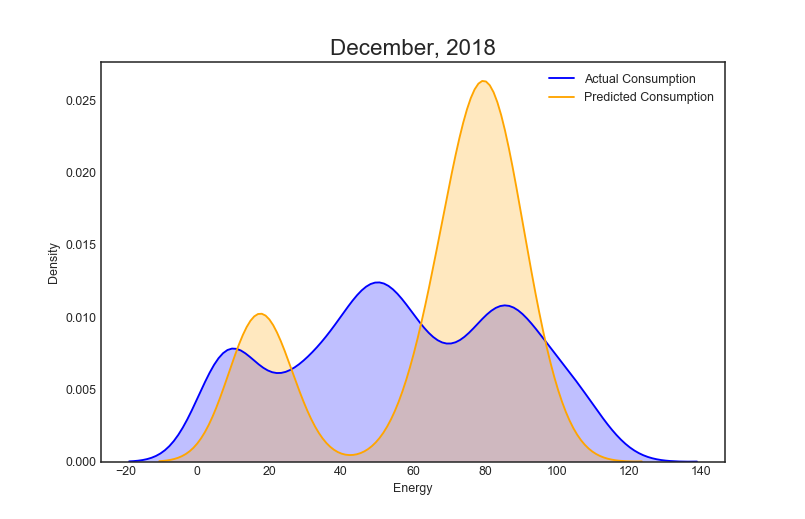

In [63]:
plot_monthly_density(actual, predicted)